## UserAgent Classifier
data: https://gist.github.com/pzb/b4b6f57144aea7827ae4

In [103]:
from urllib.request import urlopen
from io import BytesIO
import pandas as pd
from user_agents import parse

raw = "https://gist.githubusercontent.com/pzb/b4b6f57144aea7827ae4/raw/cf847b76a142955b1410c8bcef3aabe221a63db1/user-agents.txt"

def make_target(row):
    parsed = parse(row)
    if parsed.is_pc:
        return "__label__pc"
    # elif parsed.is_tablet:
    #     return "__label__tablet"
    else:
        return "__label__mobile"

df = (
    pd.read_csv(BytesIO(urlopen(raw).read()), sep='\t', names=['useragent'])
    .assign(target=lambda df: df.useragent.apply(make_target))
)[[
    'target', 'useragent'
]]
df.sample(5)

,target,useragent
505,__label__mobile,Mozilla/5.0 (Linux; Android 5.1.1; SM-G920V Bu...
546,__label__pc,Mozilla/5.0 (Windows NT 6.1) AppleWebKit/537.3...
280,__label__pc,Mozilla/5.0 (Windows NT 6.1; WOW64; Trident/7....
878,__label__pc,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_7_4)...
526,__label__mobile,Mozilla/5.0 (Linux; Android 4.1.2; GT-N8013 Bu...


<AxesSubplot:>

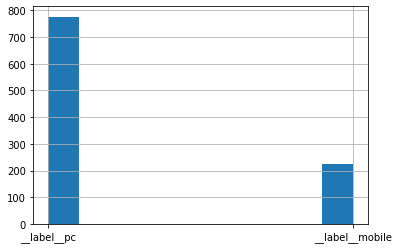

In [95]:
df.target.hist()

In [96]:
from sklearn.model_selection import train_test_split

train_idx, test_idx = train_test_split(df.index, test_size=0.2, random_state=2021)
train_idx.size, test_idx.size

(800, 200)

In [97]:
train_df = df.iloc[train_idx]
test_df = df.iloc[test_idx]
train_df.to_csv('train.tsv', sep='\t', index=False, header=None)
test_df.to_csv('test.tsv', sep='\t', index=False, header=None)

In [98]:
%%time
import fasttext

model = fasttext.train_supervised(input="train.tsv")
model.save_model("ua_classifier.bin")

CPU times: user 64.3 ms, sys: 83 ms, total: 147 ms
Wall time: 225 ms


Read 0M words
Number of words:  683
Number of labels: 2
Progress: 100.0% words/sec/thread:   49842 lr:  0.000000 avg.loss:  0.320057 ETA:   0h 0m 0s


In [99]:
sample_ua = test_df.sample().useragent.values[0]
print(sample_ua)
model.predict(sample_ua)

Mozilla/5.0 (Windows NT 6.1; Trident/7.0; ATT-IE11; rv:11.0) like Gecko


(('__label__pc',), array([0.99899966]))

In [100]:
y_pred, y_proba = model.predict(test_df.useragent.values.tolist())

In [101]:
from sklearn.metrics import classification_report

print(classification_report(
    test_df.target.values, 
    y_pred))

                 precision    recall  f1-score   support

__label__mobile       1.00      0.97      0.99        40
    __label__pc       0.99      1.00      1.00       160

       accuracy                           0.99       200
      macro avg       1.00      0.99      0.99       200
   weighted avg       1.00      0.99      0.99       200

